In [1]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,QuantileTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
MDATA_PATH = '/home/chingisbadmaev/Desktop/sirius_university/machine_learning/mdata'
DEVICE = 'cpu'

full_name = 'Chingis Badmaev'
random_state = sum(map(ord,full_name))

In [4]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

def get_market_data(ticker):
    data = []
    for date in dates:
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [5]:
ticker = 'Z.ETH'

In [6]:
mdata,pgrid,vgrid = get_market_data(ticker)
mdata = mdata.groupby(mdata.index).last()

In [7]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

In [10]:
mdata

,BEST_BID_VOL,BEST_ASK_VOL,VOLUME,DVOL,ENTROPY,COUNT,COUNT_BUY,COUNT_SELL,MO_COUNT,MO_COUNT_BUY,MO_COUNT_SELL,MO_AVG,MO_AVG_BUY,MO_AVG_SELL,BREAK_BEST_DOWN,BREAK_BEST_UP,ASK_VOLUME,BID_VOLUME
bar_time,,,,,,,,,,,,,,,,,,
2021-01-01 00:02:01.217999872,85.032,7.025,7880.090,4621.790,5.345217,2421.0,1433.0,988.0,776.0,345.0,432.0,10.154755,18.118667,3.771181,216.0,252.0,28788.139,47647.575
2021-01-01 00:05:06.065999872,0.863,1.244,3248.780,-559.924,4.837083,2055.0,940.0,1115.0,733.0,293.0,440.0,4.432169,4.588491,4.328073,375.0,244.0,33642.982,58297.440
2021-01-01 00:08:29.527000064,2.818,79.201,10123.369,-6404.833,5.248397,3486.0,936.0,2550.0,1200.0,487.0,713.0,8.436141,3.817799,11.590604,373.0,382.0,60803.179,77709.537
2021-01-01 00:10:31.216999936,3.381,1.000,4778.144,-1831.244,5.147122,2833.0,1026.0,1807.0,1126.0,536.0,590.0,4.243467,2.748974,5.601176,434.0,423.0,62556.163,82603.227
2021-01-01 00:12:11.052999936,2.293,16.376,6602.373,-1002.763,5.067033,4109.0,2180.0,1929.0,1838.0,1300.0,539.0,3.592151,2.153696,7.054857,404.0,419.0,65272.448,82534.671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 23:37:08.680000000,2.550,11.417,2260.879,1183.067,5.937544,3561.0,2189.0,1372.0,1233.0,664.0,570.0,1.833641,2.593333,0.945449,172.0,187.0,31470.634,76891.031
2021-10-31 23:42:08.324000000,0.210,2.572,2408.873,18.237,5.638741,3589.0,1620.0,1969.0,1126.0,458.0,669.0,2.139319,2.649683,1.786723,191.0,152.0,31086.624,76798.148
2021-10-31 23:47:08.182000128,6.786,0.992,1174.205,112.403,5.087318,2798.0,1307.0,1491.0,996.0,387.0,609.0,1.178921,1.662284,0.871759,156.0,121.0,31583.089,77069.527


In [9]:
n_features = mdata.shape[1]
n_features

18

In [11]:
# split to train-test chronologically

os_index_start = int(0.8*mdata.shape[0])

X_train,X_test = mdata.iloc[:os_index_start].values,mdata.iloc[os_index_start:].values
y_train,y_test = returns_ahead.iloc[:os_index_start].values,returns_ahead.iloc[os_index_start:].values

# within the train set split to real-train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)

In [12]:
fct = QuantileTransformer()
fct.fit(X_train)
X_train_fct,X_val_fct,X_test_fct = fct.transform(X_train),fct.transform(X_val),fct.transform(X_test)

tct = QuantileTransformer()
tct.fit(y_train.reshape((y_train.size,1)))
y_train_tct,y_val_tct,y_test_tct = tct.transform(y_train.reshape((y_train.size,1))).flatten(),tct.transform(y_val.reshape((y_val.size,1))).flatten(),tct.transform(y_test.reshape((y_test.size,1))).flatten()

In [46]:
X_train_fct_t = torch.tensor(X_train_fct,dtype=torch.float32,device=DEVICE)
y_train_tct_t = torch.tensor(y_train_tct,dtype=torch.float32,device=DEVICE)

X_val_fct_t = torch.tensor(X_val_fct,dtype=torch.float32,device=DEVICE)
y_val_tct_t = torch.tensor(y_val_tct,dtype=torch.float32,device=DEVICE)

X_test_fct_t = torch.tensor(X_test_fct,dtype=torch.float32,device=DEVICE)
y_test_tct_t = torch.tensor(y_test_tct,dtype=torch.float32,device=DEVICE)

In [15]:
# MMF - market microstructure features
MMFEpisode = namedtuple('MMFEpisode',['features','targets'])

In [16]:
class MMFSet(torch.utils.data.Dataset):
    def __init__(self,X,y,episode_len):
        super().__init__()
        
        assert X.shape[0] == y.size
        
        self.n_ticks,self.n_features = X.shape
        self.episode_len = episode_len
        self.features_t = torch.tensor(X,dtype=torch.float32,device=DEVICE)
        self.targets_t = torch.tensor(y,dtype=torch.float32,device=DEVICE)
    
    def __len__(self):
        return self.n_ticks-self.episode_len+1
    
    def __getitem__(self,i):
        return MMFEpisode(
            features = self.features_t[i:i+self.episode_len],
            targets = self.targets_t[i:i+self.episode_len]
        )

In [22]:
EPISODE_LEN = 128
HIDDEN_SIZE_0 = 256
HIDDEN_SIZE_1 = 128
BATCH_SIZE = 512
LEARNING_RATE = 0.01

In [23]:
mmf_train_set = MMFSet(X_train_fct,y_train_tct,EPISODE_LEN)

In [24]:
# LSTM - long short-term memory

class MMFLSTM(nn.Module):
    def __init__(self,input_size,hidden_size_0,hidden_size_1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size_0)
        self.linear_0 = nn.Linear(hidden_size_0,hidden_size_1)
        self.linear_1 = nn.Linear(hidden_size_1,1)
        
    def forward(self,x):
        lstm_out,(hidden,cell) = self.lstm.forward(x)
        lin_0_out = self.linear_0.forward(lstm_out)
        lin_0_out = torch.relu(lin_0_out)
        lin_1_out = self.linear_1.forward(lin_0_out)
        
        return lin_1_out

In [25]:
mmf_lstm = MMFLSTM(n_features,HIDDEN_SIZE_0,HIDDEN_SIZE_1)

mmf_loss_fn = F.mse_loss
mmf_optimizer = torch.optim.Adam(mmf_lstm.parameters(),lr=LEARNING_RATE)

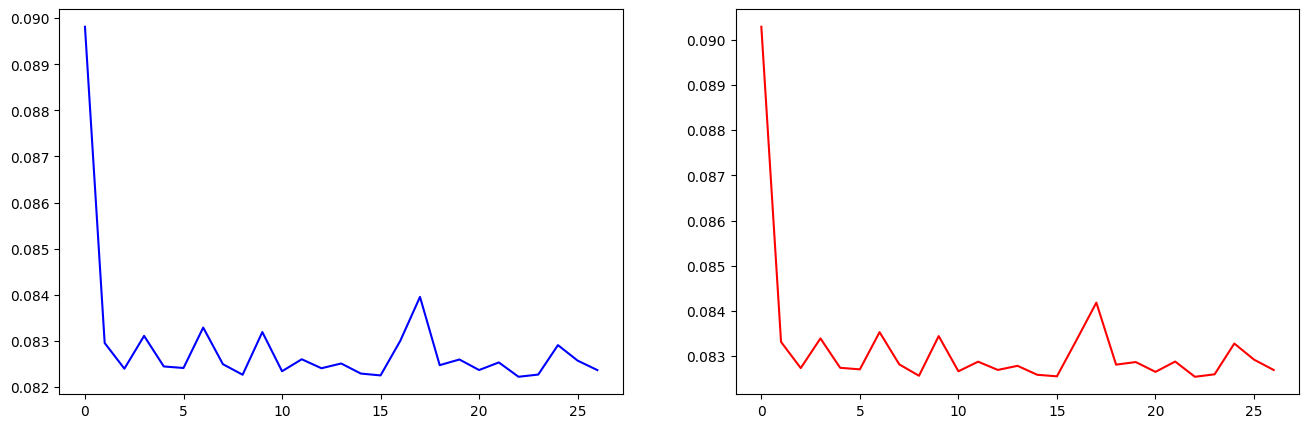

KeyboardInterrupt: 

In [26]:
train_loss_hist = []
val_loss_hist = []

iter_num = 0
for epoch in range(25):
    mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )

    for mmf_episode in mmf_train_batch_set:
        iter_num += 1
        
        predicted_targets = mmf_lstm(mmf_episode.features)[:,:,0]
        train_loss = mmf_loss_fn(predicted_targets,mmf_episode.targets)

        mmf_lstm.zero_grad()
        train_loss.backward()
        mmf_optimizer.step()
        
        if not iter_num % 20:
            mmf_lstm.train(False)
            
            train_loss = mmf_loss_fn(mmf_lstm(X_train_fct_t)[:,0],y_train_tct_t)
            train_loss_hist.append(train_loss.item())
            
            val_loss = mmf_loss_fn(mmf_lstm(X_val_fct_t)[:,0],y_val_tct_t)
            val_loss_hist.append(val_loss.item())
            
            mmf_lstm.train(True)
            
            clear_output(True)

            tlh = pd.Series(train_loss_hist)
            vlh = pd.Series(val_loss_hist)

            fig,axs = plt.subplots(1,2,figsize=(16,5))
            axs[0].plot(tlh.index,tlh.values,label='train loss',color='blue')
            axs[1].plot(vlh.index,vlh.values,label='val loss',color='red')

            plt.show()

Заметим, что графики совпадают  
Посмотрим на относительное расстояние между train_loss и val_loss 

In [45]:
abs((np.array(train_loss_hist) - np.array(val_loss_hist)) / np.array(train_loss_hist)).round(3)

array([0.005, 0.004, 0.004, 0.003, 0.004, 0.004, 0.003, 0.004, 0.004,
       0.003, 0.004, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.003,
       0.004, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004])

point (b)

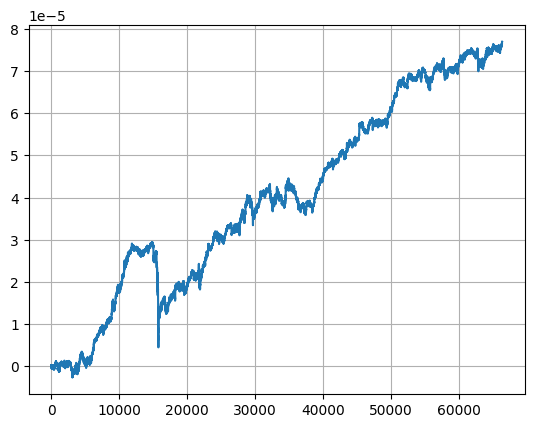

In [50]:
y_pred = mmf_lstm(X_test_fct_t).detach().numpy()
y_pred = tct.inverse_transform(y_pred).reshape(-1)

pd.Series(y_pred * y_test).cumsum().plot()
plt.grid()